# DL FOR SKIN CANCER DETECTION

# in this notebook i will try to use all my knowledge to create this application

# IMPORT DATASET


In [1]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob

# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    cancer_files = np.array(data['filenames'])
    cancer_targets = np_utils.to_categorical(np.array(data['target']), 3)
    return cancer_files, cancer_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('data/train')
valid_files, valid_targets = load_dataset('data/valid')
test_files, test_targets = load_dataset('data/test')

# load list of skin problem names
cancer_names = [item[20:-1] for item in sorted(glob("data/train/*/"))]

# print statistics about the dataset
print('There are %d total skin cancer categories.' % len(cancer_names))
print('There are %s total skin cancer images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training skin cancer images.' % len(train_files))
print('There are %d validation skin cancer images.' % len(valid_files))
print('There are %d test skin cancer images.'% len(test_files))

Using TensorFlow backend.


There are 3 total skin cancer categories.
There are 2750 total skin cancer images.

There are 2000 training skin cancer images.
There are 150 validation skin cancer images.
There are 600 test skin cancer images.


# Re-scale de image

In [2]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

In [3]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [05:40<00:00,  1.62it/s]


# Data augmentation

In [4]:
from keras.preprocessing.image import ImageDataGenerator

#create and configure augmented image generator
datagen_train = ImageDataGenerator(
    width_shift_range=0.1,  # randomly shift images horizontally (10% of total width)
    height_shift_range=0.1, # randomly shift images vertically (10% of total height)
    rotation_range=5, # randomly rotate images in the range (degrees, 0 to 180)
    horizontal_flip=False) # randomly flip images horizontally

# fit augmented image generator on data
datagen_train.fit(train_tensors)

# Model Architecture

In [5]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

model = Sequential()
model.add(Conv2D(filters=16, kernel_size=2, padding = 'same',activation='relu',input_shape=(224,224,3)))
model.add(MaxPooling2D(pool_size=2, strides=2))
model.add(Conv2D(filters=32, kernel_size=2, padding ='same',activation='relu')) 
model.add(MaxPooling2D(pool_size=2, strides=2))
model.add(Conv2D(filters=64, kernel_size=2, padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=5, strides=5))
model.add(Conv2D(filters=128, kernel_size=2, padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=5, strides=5))
model.add(Conv2D(filters=256, kernel_size=2, padding = 'same',activation='relu'))
model.add(MaxPooling2D(pool_size=2, strides=2))
model.add(Dropout(0.33))
model.add(Flatten())
model.add(Dense(500, activation='relu'))
model.add(Dropout(0.33))
model.add(Dense(3,activation='softmax'))
model.summary()

Instructions for updating:
keep_dims is deprecated, use keepdims instead
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 16)      208       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 32)      2080      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 56, 56, 64)        8256      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 11, 11, 64)        0         
_________________________________________________________________
con

# compile de model

In [6]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [7]:
from keras.callbacks import ModelCheckpoint

batch_size = 10
epochs = 30

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.Resnet50.hdf5', verbose=1, save_best_only=True)

model.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 2000 samples, validate on 150 samples
Epoch 1/30
2000/2000 [==============================] - 18s - loss: 0.8578 - acc: 0.6845 - val_loss: 1.0390 - val_acc: 0.5200
Epoch 2/30
2000/2000 [==============================] - 7s - loss: 0.8216 - acc: 0.6860 - val_loss: 0.8981 - val_acc: 0.5200
Epoch 3/30
2000/2000 [==============================] - 7s - loss: 0.7916 - acc: 0.6860 - val_loss: 0.8621 - val_acc: 0.5200
Epoch 4/30
2000/2000 [==============================] - 7s - loss: 0.7711 - acc: 0.6870 - val_loss: 0.8343 - val_acc: 0.5200
Epoch 5/30


2000/2000 [==============================] - 7s - loss: 0.7423 - acc: 0.6950 - val_loss: 0.9078 - val_acc: 0.5400
Epoch 6/30
2000/2000 [==============================] - 7s - loss: 0.7188 - acc: 0.7005 - val_loss: 0.7902 - val_acc: 0.6067
Epoch 7/30
2000/2000 [==============================] - 7s - loss: 0.7012 - acc: 0.6995 - val_loss: 0.7771 - val_acc: 0.6133
Epoch 8/30
2000/2000 [==============================] - 7s - loss: 0.6952 - acc: 0.7040 - val_loss: 0.7417 - val_acc: 0.6533
Epoch 9/30


2000/2000 [==============================] - 7s - loss: 0.6851 - acc: 0.7095 - val_loss: 0.8155 - val_acc: 0.6267
Epoch 10/30
2000/2000 [==============================] - 7s - loss: 0.6732 - acc: 0.7170 - val_loss: 0.7815 - val_acc: 0.6333
Epoch 11/30
2000/2000 [==============================] - 7s - loss: 0.6683 - acc: 0.7260 - val_loss: 0.7653 - val_acc: 0.6200
Epoch 12/30
2000/2000 [==============================] - 7s - loss: 0.6492 - acc: 0.7235 - val_loss: 0.7993 - val_acc: 0.6267
Epoch 13/30


2000/2000 [==============================] - 7s - loss: 0.6680 - acc: 0.7230 - val_loss: 0.8031 - val_acc: 0.6133
Epoch 14/30
2000/2000 [==============================] - 7s - loss: 0.6423 - acc: 0.7360 - val_loss: 0.8519 - val_acc: 0.6067
Epoch 15/30
2000/2000 [==============================] - 7s - loss: 0.6212 - acc: 0.7475 - val_loss: 1.0668 - val_acc: 0.6067
Epoch 16/30
2000/2000 [==============================] - 7s - loss: 0.6118 - acc: 0.7405 - val_loss: 0.8422 - val_acc: 0.6267
Epoch 17/30


2000/2000 [==============================] - 7s - loss: 0.6047 - acc: 0.7455 - val_loss: 0.7953 - val_acc: 0.6467
Epoch 18/30
2000/2000 [==============================] - 7s - loss: 0.5876 - acc: 0.7530 - val_loss: 0.9413 - val_acc: 0.6400
Epoch 19/30
2000/2000 [==============================] - 7s - loss: 0.5819 - acc: 0.7560 - val_loss: 0.9947 - val_acc: 0.6133
Epoch 20/30
2000/2000 [==============================] - 7s - loss: 0.5581 - acc: 0.7585 - val_loss: 0.8556 - val_acc: 0.6400
Epoch 21/30


2000/2000 [==============================] - 7s - loss: 0.5504 - acc: 0.7565 - val_loss: 1.1741 - val_acc: 0.6067
Epoch 22/30
2000/2000 [==============================] - 7s - loss: 0.5406 - acc: 0.7790 - val_loss: 1.0004 - val_acc: 0.6200
Epoch 23/30
2000/2000 [==============================] - 7s - loss: 0.5425 - acc: 0.7840 - val_loss: 0.8541 - val_acc: 0.6800
Epoch 24/30
2000/2000 [==============================] - 7s - loss: 0.5152 - acc: 0.7925 - val_loss: 0.9154 - val_acc: 0.6133
Epoch 25/30


2000/2000 [==============================] - 7s - loss: 0.5156 - acc: 0.7895 - val_loss: 1.0077 - val_acc: 0.6067
Epoch 26/30
2000/2000 [==============================] - 7s - loss: 0.5142 - acc: 0.7960 - val_loss: 0.9502 - val_acc: 0.5733
Epoch 27/30
2000/2000 [==============================] - 7s - loss: 0.4913 - acc: 0.8045 - val_loss: 1.2014 - val_acc: 0.5933
Epoch 28/30
2000/2000 [==============================] - 7s - loss: 0.4659 - acc: 0.8115 - val_loss: 1.1089 - val_acc: 0.6133
Epoch 29/30


2000/2000 [==============================] - 7s - loss: 0.5015 - acc: 0.8075 - val_loss: 1.1321 - val_acc: 0.6533
Epoch 30/30
2000/2000 [==============================] - 7s - loss: 0.4724 - acc: 0.8045 - val_loss: 1.3293 - val_acc: 0.6200


# load the models

In [7]:
model.load_weights('saved_models/weights.best.Resnet50.hdf5')


In [8]:

# get index of predicted skin cancer for each image in test set
skin_cancer_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(skin_cancer_predictions)==np.argmax(test_targets, axis=1))/len(skin_cancer_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 70.0000%


In [12]:
test = path_to_tensor(train_files[90]).astype('float32')/255
print(model.predict(test))

[[0.29561213 0.5579704  0.14641745]]


# PUT THE DATA ON THE .CSV FILE AND SCORE THE CATEGORYS


In [19]:
import pandas as pd
csv = pd.read_csv('sample_predictions.csv')
result_csv = csv['Id']
tensor_csv = paths_to_tensor(result_csv).astype('float32')/255


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [05:37<00:00,  6.74it/s]


In [20]:
prediction = model.predict(tensor_csv)
csv['task_1'] = prediction[:,0]
csv['task_2'] = prediction[:,2]
csv

,Id,task_1,task_2
0,data/test/melanoma/ISIC_0012258.jpg,0.099544,0.584641
1,data/test/melanoma/ISIC_0012356.jpg,0.191968,0.429290
2,data/test/melanoma/ISIC_0012369.jpg,0.207068,0.328933
3,data/test/melanoma/ISIC_0012395.jpg,0.227312,0.074357
4,data/test/melanoma/ISIC_0012425.jpg,0.158352,0.487594
5,data/test/melanoma/ISIC_0012758.jpg,0.068709,0.000832
6,data/test/melanoma/ISIC_0012989.jpg,0.139933,0.105742
7,data/test/melanoma/ISIC_0013072.jpg,0.182745,0.257080
8,data/test/melanoma/ISIC_0013073.jpg,0.158595,0.451142
9,data/test/melanoma/ISIC_0013242.jpg,0.208413,0.333153


# RUNNING GET_RESULTS.PY

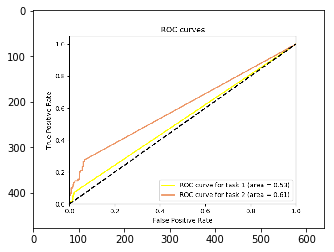

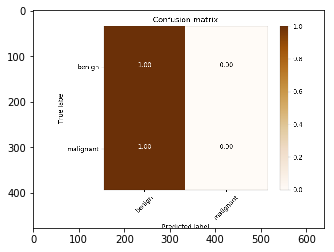

My score Was: Category 1 Score: 0.526 / Category 2 Score: 0.606 / Category 3 Score: 0.566 


In [35]:
import cv2
import matplotlib.pyplot as plt                        
%matplotlib inline


img1 = cv2.imread('figure_1.png')
img2 = cv2.imread('figure_2.png')
plt.imshow(img1)
plt.show()
plt.imshow(img2)
plt.show()
print("My score Was: Category 1 Score: 0.526 / Category 2 Score: 0.606 / Category 3 Score: 0.566 ")
